In [365]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
import tensorflow as tf
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


np.random.seed(42)
tf.random.set_seed(42)

In [366]:
df = pd.read_csv('/content/drive/MyDrive/Stores.csv')

In [367]:
df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [368]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Store ID              896 non-null    int64
 1   Store_Area            896 non-null    int64
 2   Items_Available       896 non-null    int64
 3   Daily_Customer_Count  896 non-null    int64
 4   Store_Sales           896 non-null    int64
dtypes: int64(5)
memory usage: 35.1 KB


#Exploratory data analysis

In [369]:
unique_values = df.nunique()

print(unique_values)


Store ID                896
Store_Area              583
Items_Available         616
Daily_Customer_Count    130
Store_Sales             816
dtype: int64


In [370]:
store_ids =df['Store ID ']
df.drop(columns=['Store ID '], inplace=True)

In [371]:
df.describe()

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
count,896.000000,896.000000,896.000000,896.000000
mean,1485.409598,1782.035714,786.350446,59351.305804
std,250.237011,299.872053,265.389281,17190.741895
min,775.000000,932.000000,10.000000,14920.000000
25%,1316.750000,1575.500000,600.000000,46530.000000
50%,1477.000000,1773.500000,780.000000,58605.000000
75%,1653.500000,1982.750000,970.000000,71872.500000
max,2229.000000,2667.000000,1560.000000,116320.000000


In [372]:
for column_name in ["Store_Area", "Items_Available", "Daily_Customer_Count" ,"Store_Sales"]:

    # Compute statistics
    mean_value = df[column_name].mean()

    # Create a histogram trace
    hist_trace = go.Histogram(
        x=df[column_name],
        histnorm='probability density',
        name="Histogram",
        marker=dict(
            color='blue',
            line=dict(
                color='black',
                width=1
            )
        ),
        opacity=0.7
    )

    # Create a KDE trace
    kde_x_values = np.linspace(df[column_name].min(), df[column_name].max(), 200)
    kde_y_values = stats.gaussian_kde(df[column_name].values)(kde_x_values)
    kde_trace = go.Scatter(
        x=kde_x_values,
        y=kde_y_values,
        mode='lines',
        name="KDE",
        line=dict(
            color='black',
            width=1.5
        )
    )

    # Create a vertical line trace for the mean
    mean_trace = go.Scatter(
        x=[mean_value, mean_value],
        y=[0, max(kde_y_values)],
        mode='lines',
        name="Mean",
        line=dict(
            color='red',
            width=1,
            dash='dash'
        ),
        hovertemplate=f"Mean (μ): {mean_value:.2f}<extra></extra>"
    )

    # Create a figure and add traces
    fig = go.Figure([hist_trace, kde_trace, mean_trace])

    # Update layout
    fig.update_layout(
        title=f"{column_name} Distribution",
        xaxis_title="Score",
        yaxis_title="Density",
        bargap=0.01,  # gap between bars of histogram
        bargroupgap=0.1  # gap between bars of different groups
    )

    fig.show()


In [373]:
for column_name in ["Store_Area", "Items_Available", "Daily_Customer_Count"]:
    # Create a box trace
    box_trace = go.Box(
        y=df[column_name],
        name=column_name,
        marker_color='blue'
    )

    # Create a figure and add trace
    fig = go.Figure(box_trace)

    # Update layout
    fig.update_layout(
        title=f"{column_name} Box Plot",
        yaxis_title=column_name
    )

    fig.show()


In [374]:
correlation_matrix = df.corr()

# generate a heatmap
fig = ff.create_annotated_heatmap(
    z=correlation_matrix.values,
    x=list(correlation_matrix.columns),
    y=list(correlation_matrix.index),
    annotation_text=correlation_matrix.round(2).values,
    showscale=True,
    colorscale="Viridis"
)

# Update layout
fig.update_layout(
    title='Correlation Matrix',
    xaxis=dict(title='Variable', side='bottom'),
    yaxis=dict(title='Variable'),
    width=800,
    height=800
)

fig.show()


#Data Preprocessing and Machine Learning

In [375]:
# Select the columns to be used for LOF analysis
columns = ["Store_Area", "Items_Available", "Daily_Customer_Count"]

# Create a subset DataFrame with the selected columns
subset_df = df[columns]

# Create an instance of the LocalOutlierFactor model
lof = LocalOutlierFactor(n_neighbors=5)


outlier_scores = lof.fit_predict(subset_df)

# Create a mask to identify the outliers
outlier_mask = outlier_scores == -1

# Get the outliers from the original DataFrame
outliers = df[outlier_mask]

print("Outliers:")
print(outliers)


Outliers:
     Store_Area  Items_Available  Daily_Customer_Count  Store_Sales
39         1270             1516                    10        45480
54         1570             1898                   980        64090
60         1704             2045                   300        71300
71         1152             1380                   530        33580
91         2169             2617                   600        67080
94         1921             2305                  1470        77120
124        1164             1390                   370        35510
151        1662             1986                    70        63730
158         775              932                  1090        42530
163        2044             2474                   340        80340
230        1347             1628                   120        72350
259        1145             1370                   350        38210
298        1471             1768                   780        70610
349        1886             2228      

In [376]:
# Drop the outliers from the original DataFrame
df_no_outliers = df.drop(outliers.index)
df_no_outliers.head()


,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1659,1961,530,66490
1,1461,1752,210,39820
2,1340,1609,720,54010
3,1451,1748,620,53730
4,1770,2111,450,46620


In [377]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871 entries, 0 to 895
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Store_Area            871 non-null    int64
 1   Items_Available       871 non-null    int64
 2   Daily_Customer_Count  871 non-null    int64
 3   Store_Sales           871 non-null    int64
dtypes: int64(4)
memory usage: 34.0 KB


In [378]:
# Create a scaler object
scaler = StandardScaler()

# Fit the scaler to the features and transform
scaled_data = scaler.fit_transform(df_no_outliers)

df_scaled = pd.DataFrame(scaled_data, columns=df.columns)
df_scaled.head()

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,0.716871,0.617223,-1.017846,0.425238
1,-0.094681,-0.097522,-2.270967,-1.135753
2,-0.590628,-0.586558,-0.273805,-0.305215
3,-0.135668,-0.111201,-0.665406,-0.321603
4,1.171831,1.130197,-1.331126,-0.737750


In [379]:
# 'Store_Sales' is our target/dependent variable
X = df_scaled.drop('Store_Sales', axis=1)
y = df_scaled['Store_Sales']

In [380]:
# Split the scaled data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [381]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

lr_pred =lr_model.predict(X_test)

lr_mse = mean_squared_error(y_test, lr_pred)
lr_mae = mean_absolute_error(y_test, lr_pred)

score_lr = lr_model.score(X_train, y_train)
r2_lr = r2_score(y_test, lr_pred)



# Print the evaluation metrics
print('Linear Regression')
print("MSE: %.2f" % lr_mse)
print("MAE: %.2f" % lr_mae)
print("Training score: ", score_lr)
print("R2_score : %.2f" % r2_lr)

Linear Regression
MSE: 1.14
MAE: 0.88
Training score:  0.00890566231507739
R2_score : 0.01


#Neural Network

In [382]:
# Define model
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train model
model.fit(X_train, y_train, epochs=1500, batch_size=32, verbose=2)

# Predict the 'Store_Sales' for the test set
nn_predictions = model.predict(X_test)

# Compute evaluation metrics
mse_nn = mean_squared_error(y_test, nn_predictions)
mae_nn  = mean_absolute_error(y_test, nn_predictions)
score_nn  = model.evaluate(X_train, y_train)
r2_nn  = r2_score(y_test, nn_predictions)

# Print the evaluation metrics
print('Neural Network')
print("MSE: %.2f" % mse_nn )
print("MAE: %.2f" % mae_nn )
print("Training loss: %.2f" % score_nn )
print("R2_score : %.2f" % r2_nn)


Epoch 1/1500
22/22 - 1s - loss: 1.5034 - 1s/epoch - 52ms/step
Epoch 2/1500
22/22 - 0s - loss: 1.1819 - 26ms/epoch - 1ms/step
Epoch 3/1500
22/22 - 0s - loss: 1.0506 - 31ms/epoch - 1ms/step
Epoch 4/1500
22/22 - 0s - loss: 1.0016 - 27ms/epoch - 1ms/step
Epoch 5/1500
22/22 - 0s - loss: 0.9767 - 26ms/epoch - 1ms/step
Epoch 6/1500
22/22 - 0s - loss: 0.9678 - 29ms/epoch - 1ms/step
Epoch 7/1500
22/22 - 0s - loss: 0.9633 - 28ms/epoch - 1ms/step
Epoch 8/1500
22/22 - 0s - loss: 0.9591 - 38ms/epoch - 2ms/step
Epoch 9/1500
22/22 - 0s - loss: 0.9579 - 32ms/epoch - 1ms/step
Epoch 10/1500
22/22 - 0s - loss: 0.9550 - 29ms/epoch - 1ms/step
Epoch 11/1500
22/22 - 0s - loss: 0.9544 - 28ms/epoch - 1ms/step
Epoch 12/1500
22/22 - 0s - loss: 0.9542 - 33ms/epoch - 1ms/step
Epoch 13/1500
22/22 - 0s - loss: 0.9536 - 39ms/epoch - 2ms/step
Epoch 14/1500
22/22 - 0s - loss: 0.9528 - 29ms/epoch - 1ms/step
Epoch 15/1500
22/22 - 0s - loss: 0.9524 - 32ms/epoch - 1ms/step
Epoch 16/1500
22/22 - 0s - loss: 0.9519 - 32ms/epo

#Decision Tree Regressor

In [383]:
# Initialize the model
dt_model = DecisionTreeRegressor(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Predict the 'Store_Sales' for the test set
dt_predictions = dt_model.predict(X_test)

# Compute evaluation metrics
mse_dt = mean_squared_error(y_test, dt_predictions)
mae_dt = mean_absolute_error(y_test, dt_predictions)
score_dt = dt_model.score(X_train, y_train)

# Compute R-squared score
r2_dt = r2_score(y_test, dt_predictions)

# Print the evaluation metrics
print('Decision Tree')
print("MSE: %.2f" % mse_dt)
print("MAE: %.2f" % mae_dt)
print("Training score: %.2f" % score_dt)
print("R2_score : %.2f" % r2_dt)


Decision Tree
MSE: 2.39
MAE: 1.25
Training score: 1.00
R2_score : -1.08


#Comparison

In [384]:
# Define the models and their respective evaluation metrics
models = ['Linear Regression', 'Neural Network','Decision Tree' ]
mse = [lr_mse, mse_nn, mse_dt]
mae = [lr_mae, mae_nn, mae_dt]
r2 = [r2_lr, r2_nn, r2_dt]

# Create bar traces for each metric
trace_mse = go.Bar(x=models, y=mse, name='MSE')
trace_mae = go.Bar(x=models, y=mae, name='MAE')
trace_r2 = go.Bar(x=models, y=r2, name='R2 Score')

# Create a layout for the plot
layout = go.Layout(
    title='Comparison of Evaluation Metrics',
    xaxis_title='Models',
    yaxis_title='Metric Value'
)

# Create a figure and add the traces to it
fig = go.Figure(data=[trace_mse,trace_mae, trace_r2], layout=layout)

# Show the plot
fig.show()


# Data Mining

In [385]:
df_avgs = df.copy()
df_avgs.head()

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1659,1961,530,66490
1,1461,1752,210,39820
2,1340,1609,720,54010
3,1451,1748,620,53730
4,1770,2111,450,46620


In [386]:
df_avgs['ratio_items/cutomers'] = df_avgs['Items_Available']/df_avgs['Daily_Customer_Count']
df_avgs['ratio_size/customers'] = df_avgs['Store_Area']/df_avgs['Daily_Customer_Count']
df_avgs['ratio_size/items']     = df_avgs['Store_Area']/df_avgs['Items_Available']
df_avgs['target_sales'] = df['Store_Sales']

df_avgs.head()


,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,ratio_items/cutomers,ratio_size/customers,ratio_size/items,target_sales
0,1659,1961,530,66490,3.700000,3.130189,0.845997,66490
1,1461,1752,210,39820,8.342857,6.957143,0.833904,39820
2,1340,1609,720,54010,2.234722,1.861111,0.832815,54010
3,1451,1748,620,53730,2.819355,2.340323,0.830092,53730
4,1770,2111,450,46620,4.691111,3.933333,0.838465,46620


In [387]:
df_avgs.drop(['Store_Area','Items_Available','Daily_Customer_Count','Store_Sales'],axis = 1, inplace = True)

In [388]:
df_avgs.head()

,ratio_items/cutomers,ratio_size/customers,ratio_size/items,target_sales
0,3.700000,3.130189,0.845997,66490
1,8.342857,6.957143,0.833904,39820
2,2.234722,1.861111,0.832815,54010
3,2.819355,2.340323,0.830092,53730
4,4.691111,3.933333,0.838465,46620


# Clustering Data

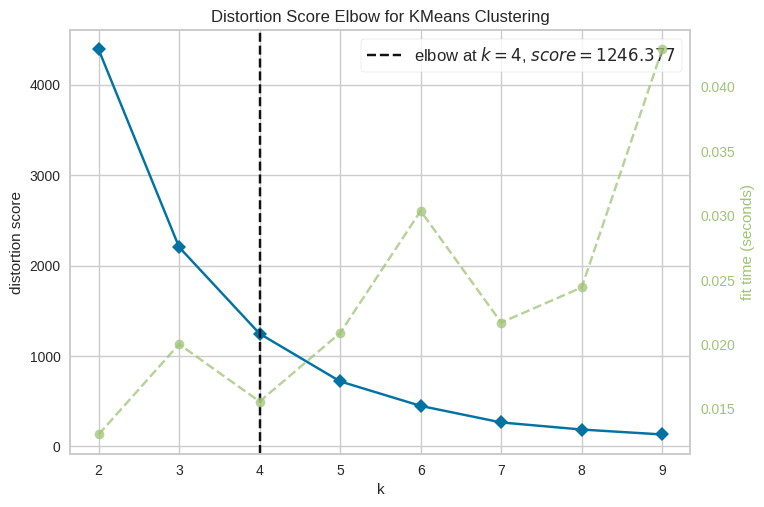

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [389]:
# Determine the optimal number of clusters using the KElbowVisualizer

x= df_avgs.drop('target_sales',axis= 1)
kmeans_model = KMeans(n_init=10)
visualizer = KElbowVisualizer(kmeans_model, k=(2, 10),n_init =10)  # Try different values of k
visualizer.fit(x)
visualizer.show()


In [390]:
kmeans_model = KMeans(n_clusters=4,n_init=10, random_state=42)
x['Cluster'] = kmeans_model.fit_predict(x)
x.head()

,ratio_items/cutomers,ratio_size/customers,ratio_size/items,Cluster
0,3.700000,3.130189,0.845997,2
1,8.342857,6.957143,0.833904,2
2,2.234722,1.861111,0.832815,0
3,2.819355,2.340323,0.830092,0
4,4.691111,3.933333,0.838465,2


In [391]:
y = df_avgs['target_sales']

sales_join = x.join(y)
sales_join.columns

Index(['ratio_items/cutomers', 'ratio_size/customers', 'ratio_size/items',
       'Cluster', 'target_sales'],
      dtype='object')

In [392]:
sales_join.head()

,ratio_items/cutomers,ratio_size/customers,ratio_size/items,Cluster,target_sales
0,3.700000,3.130189,0.845997,2,66490
1,8.342857,6.957143,0.833904,2,39820
2,2.234722,1.861111,0.832815,0,54010
3,2.819355,2.340323,0.830092,0,53730
4,4.691111,3.933333,0.838465,2,46620


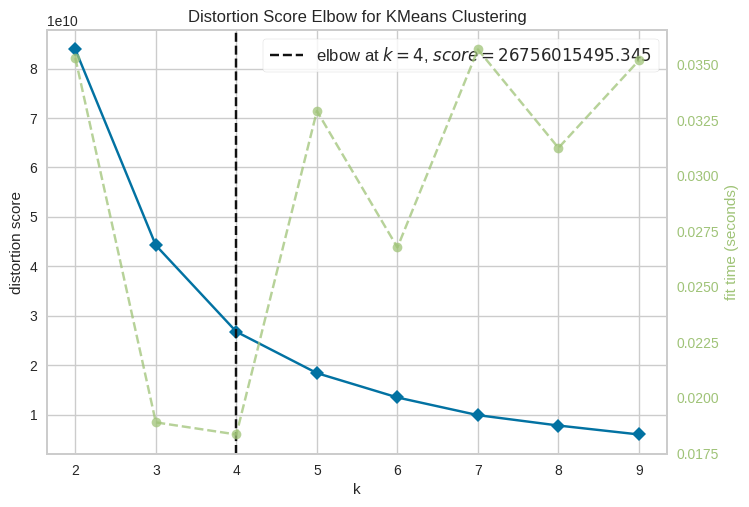

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [393]:
sales_x = sales_join[['Cluster','target_sales']]


kmeans_model = KMeans(n_init=10)
visualizer = KElbowVisualizer(kmeans_model, k=(2, 10),n_init =10)  # Try different values of k
visualizer.fit(sales_x)
visualizer.show()



In [394]:
kmeans_model = KMeans(n_clusters=4,n_init=10, random_state=42)
x['Target_Groups'] = kmeans_model.fit_predict(sales_x)
x.head()

,ratio_items/cutomers,ratio_size/customers,ratio_size/items,Cluster,Target_Groups
0,3.700000,3.130189,0.845997,2,0
1,8.342857,6.957143,0.833904,2,3
2,2.234722,1.861111,0.832815,0,2
3,2.819355,2.340323,0.830092,0,2
4,4.691111,3.933333,0.838465,2,2


In [395]:
combined_df = pd.concat([x, y], axis=1)
combined_df.head()

,ratio_items/cutomers,ratio_size/customers,ratio_size/items,Cluster,Target_Groups,target_sales
0,3.700000,3.130189,0.845997,2,0,66490
1,8.342857,6.957143,0.833904,2,3,39820
2,2.234722,1.861111,0.832815,0,2,54010
3,2.819355,2.340323,0.830092,0,2,53730
4,4.691111,3.933333,0.838465,2,2,46620


In [396]:
# Select the columns you want to scale
columns_to_scale = ['ratio_items/cutomers', 'ratio_size/customers', 'ratio_size/items', 'target_sales']

# Extract the columns you want to scale into a separate DataFrame
X = combined_df[columns_to_scale]

# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
X_scaled = scaler.fit_transform(X)

# Replace the original columns in the DataFrame with the scaled values
combined_df[columns_to_scale] = X_scaled


x= combined_df.drop('target_sales',axis= 1)
y = combined_df['target_sales']

In [397]:
combined_df.head()

,ratio_items/cutomers,ratio_size/customers,ratio_size/items,Cluster,Target_Groups,target_sales
0,0.164347,0.173896,1.907899,2,0,0.415496
1,1.047848,1.043537,0.056146,2,3,-1.136787
2,-0.114484,-0.114491,-0.110564,0,2,-0.310882
3,-0.003233,-0.005594,-0.527666,0,2,-0.327179
4,0.352948,0.356404,0.754575,2,2,-0.741004


# Now Doing the Models Prediction on the clustered Data

## Second Linear Regression

In [398]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

In [399]:
new_lr_model = LinearRegression()
new_lr_model.fit(X_train, y_train)
new_lr_pred =new_lr_model.predict(X_test)


new_lr_mse = mean_squared_error(y_test, new_lr_pred)
new_lr_mae = mean_absolute_error(y_test, new_lr_pred)

new_score_lr = new_lr_model.score(X_train, y_train)
new_r2_lr = r2_score(y_test, new_lr_pred)


# Print the evaluation metrics
print('Linear Regression')
print("MSE: %.2f" % new_lr_mse)
print("MAE: %.2f" % new_lr_mae)
print("Training score: ", new_score_lr)
print("R2_score : %.2f" % new_r2_lr)

Linear Regression
MSE: 0.47
MAE: 0.51
Training score:  0.5570473875642654
R2_score : 0.49


In [400]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr_pred =dtr.predict(X_test)

new_mse_dt = mean_squared_error(y_test, dtr_pred)
new_mae_dt = mean_absolute_error(y_test, dtr_pred)

new_score_dt = dtr.score(X_train, y_train)
new_r2_dt =r2_score(y_test,  dtr_pred)

print('DecisionTree Regressor')
print("MSE: %.2f" % new_mse_dt)
print("MAE: %.2f" % (new_mae_dt))
print("Training score: ", new_score_dt)
print("R2_score : %.2f"%(new_r2_dt))

DecisionTree Regressor
MSE: 0.20
MAE: 0.34
Training score:  1.0
R2_score : 0.79
